<a href="https://colab.research.google.com/github/mpovolocky-a11y/ML_IT_Support_Classification/blob/step3-model-training/ML_IT_Support_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Задача: Многоклассовая классификация текстовых обращений.

Цель: Автоматизировать назначение «Рабочей группы» (12 категорий) на основе текста обращения («Описание»).

Входные данные: ~8000 строк в формате CSV/Excel.

Ожидаемый результат: Модель, которая с высокой точностью (F1-weighted > 0.8) распределяет заявки.





In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Настроим графики, чтобы они были красивыми
sns.set(style="whitegrid")

In [10]:
# Загрузка данных

# Загрузим файл
df = pd.read_excel('sample_data/ML_dataset.xlsx')

# Выведем первые 5 строк, чтобы убедиться, что всё считалось правильно
df.head()

,Описание,Рабочая группа
0,ag тема: оценка поощрения. оценка 1. название ...,РГ АГ.Маркет.Оценки
1,ag тема: оценка поощрения. оценка 1. название ...,РГ АГ.Маркет.Оценки
2,ag тема: оценка поощрения. оценка 1. название ...,РГ АГ.Маркет.Оценки
3,ag тема: оценка поощрения. оценка 1. название ...,РГ АГ.Маркет.Оценки
4,ag тема: оценка поощрения. оценка 1. название ...,РГ АГ.Маркет.Оценки


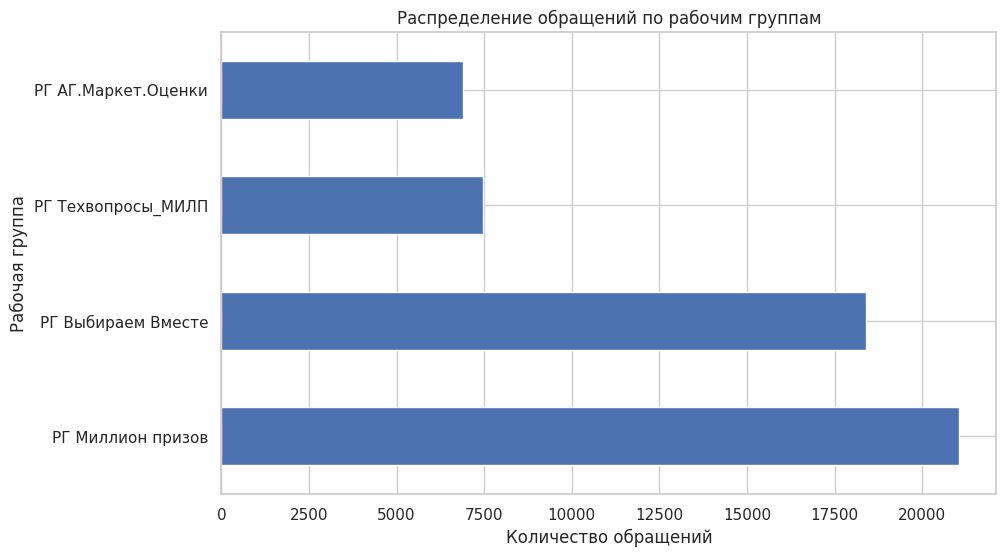

Рабочая группа
РГ Миллион призов      21063
РГ Выбираем Вместе     18399
РГ Техвопросы_МИЛП      7471
РГ АГ.Маркет.Оценки     6909
Name: count, dtype: int64


In [11]:
# Проверка "Баланса классов"

plt.figure(figsize=(10,6))
df['Рабочая группа'].value_counts().plot(kind='barh')
plt.title('Распределение обращений по рабочим группам')
plt.xlabel('Количество обращений')
plt.ylabel('Рабочая группа')
plt.show()

# Выведем точные числа
print(df['Рабочая группа'].value_counts())

In [12]:
# Проверим, есть ли пустые описания
print("Пустых описаний:", df['Описание'].isnull().sum())

# Удалим строки, где описание пустое (если они есть)
df = df.dropna(subset=['Описание'])

# Посмотрим на 10 случайных текстов, чтобы понять, какой "мусор" там есть
for text in df['Описание'].sample(10).values:
    print("-" * 30)
    print(text)

Пустых описаний: 0
------------------------------
обращение создано по электронному письму, отправленному с cbet2006@yandex.ru внешняя почта: если отправитель почты неизвестен, не переходите по ссылкам, не сообщайте пароль, не запускайте вложения и сообщите коллегам из службы безопасности по адресу ditantifishing@mos.ru добрый день. можно ли отменить этот заказ, так как на сайте этого магазина не удается его применить. -- с уважением! обращение перенаправлено с support_mp@mos.ru
------------------------------
ag тема: оценка поощрения. оценка 2. название поощрения: ланч-бокс в термосумке, 1200 мл. ссылка на поощрение: . комментарий пользователя: перекладина меньше по размеру, падает на бок, молния разходится в двух местах, контейнеры крепятся резинкой, которая в итоге растянется. номер заказа: 18765326
------------------------------
сделан заказ городскими баллами. . с - 15109208 от 07. 06. 2024 ( списано 4000 баллов) для аптеке столички промокод не читается промокод в аптеке не читает

In [13]:
# Предобработка и очистка данных (хоть у нас их ноль, повезло)

def clean_text(text):
    text = str(text).lower() # в нижний регистр
    text = re.sub(r'https?://\S+|www\.\S+', ' [url] ', text) # убираем ссылки
    text = re.sub(r'\b\d+\b', ' ', text) # убираем отдельно стоящие цифры (ID, даты)
    text = re.sub(r'[^\w\s]', ' ', text) # убираем пунктуацию
    text = re.sub(r'\s+', ' ', text).strip() # убираем лишние пробелы
    return text

# Применяем очистку (займет немного времени, так как данных много)
df['Описание_очищенное'] = df['Описание'].apply(clean_text)

# Посмотрим результат
df[['Описание', 'Описание_очищенное']].head()

,Описание,Описание_очищенное
0,ag тема: оценка поощрения. оценка 1. название ...,ag тема оценка поощрения оценка название поощр...
1,ag тема: оценка поощрения. оценка 1. название ...,ag тема оценка поощрения оценка название поощр...
2,ag тема: оценка поощрения. оценка 1. название ...,ag тема оценка поощрения оценка название поощр...
3,ag тема: оценка поощрения. оценка 1. название ...,ag тема оценка поощрения оценка название поощр...
4,ag тема: оценка поощрения. оценка 1. название ...,ag тема оценка поощрения оценка название поощр...


In [16]:
# Запускаем код для очистки от

# 1. Установка лемматизатора
!pip install pymorphy3

import pymorphy3
import re
from tqdm import tqdm

morph = pymorphy3.MorphAnalyzer()

def preprocess_text(text):
    if not isinstance(text, str):
        return ""

    # Приводим к нижнему регистру
    text = text.lower()

    # Убираем HTML-сущности типа &quot;
    text = re.sub(r'&\w+;', ' ', text)

    # Убираем email-адреса
    text = re.sub(r'\S+@\S+', ' ', text)

    # Убираем ссылки
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)

    # Убираем цифры (номера заказов, даты, телефоны)
    text = re.sub(r'\b\d+\b', ' ', text)

    # Убираем всё, кроме букв (пунктуация, спецсимволы)
    text = re.sub(r'[^\w\s]', ' ', text)

    # Лемматизация (приведение к начальной форме)
    words = text.split()
    # Оставляем слова длиннее 2 символов, чтобы убрать 'и', 'в', 'на', 'ag'
    lemmatized_words = [morph.parse(word)[0].normal_form for word in words if len(word) > 2]

    return " ".join(lemmatized_words)

# Запуск обработки (на 50к строках это займет около 5-8 минут)
print("Начинаю глубокую очистку и лемматизацию...")
df['text_cleaned'] = [preprocess_text(t) for t in tqdm(df['Описание'])]

print("\nОчистка завершена!")

# Посмотрим на результат
df[['Описание', 'text_cleaned']].head(10)

Начинаю глубокую очистку и лемматизацию...


100%|██████████| 53842/53842 [03:44<00:00, 240.36it/s]



Очистка завершена!


,Описание,text_cleaned
0,ag тема: оценка поощрения. оценка 1. название ...,тема оценка поощрение оценка название поощрени...
1,ag тема: оценка поощрения. оценка 1. название ...,тема оценка поощрение оценка название поощрени...
2,ag тема: оценка поощрения. оценка 1. название ...,тема оценка поощрение оценка название поощрени...
3,ag тема: оценка поощрения. оценка 1. название ...,тема оценка поощрение оценка название поощрени...
4,ag тема: оценка поощрения. оценка 1. название ...,тема оценка поощрение оценка название поощрени...
5,ag тема: оценка поощрения. оценка 2. название ...,тема оценка поощрение оценка название поощрени...
6,ag тема: оценка поощрения. оценка 1. название ...,тема оценка поощрение оценка название поощрени...
7,ag тема: оценка поощрения. оценка 1. название ...,тема оценка поощрение оценка название поощрени...
8,ag тема: оценка поощрения. оценка 1. название ...,тема оценка поощрение оценка название поощрени...
9,ag тема: оценка поощрения. оценка 1. название ...,тема оценка поощрение оценка название поощрени...


In [17]:
# Разделение на выборки (Train/Val/Test)

from sklearn.model_selection import train_test_split

# 1. Сначала выделим 20% на финальный тест
train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Рабочая группа'])

# 2. Оставшееся делим на обучение и валидацию (15% от остатка)
train_df, val_df = train_test_split(train_val_df, test_size=0.15, random_state=42, stratify=train_val_df['Рабочая группа'])

print(f"Обучение: {len(train_df)} строк")
print(f"Валидация: {len(val_df)} строк")
print(f"Тест: {len(test_df)} строк")

Обучение: 36612 строк
Валидация: 6461 строк
Тест: 10769 строк


In [18]:
# Векторизация (TF-IDF)

from sklearn.feature_extraction.text import TfidfVectorizer

# Ограничимся 10 000 самых важных слов и словосочетаний (биграмм)
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))

# Обучаем векторизатор ТОЛЬКО на тренировочных данных
X_train = tfidf.fit_transform(train_df['text_cleaned'])

# Трансформируем остальные выборки
X_val = tfidf.transform(val_df['text_cleaned'])
X_test = tfidf.transform(test_df['text_cleaned'])

y_train = train_df['Рабочая группа']
y_val = val_df['Рабочая группа']
y_test = test_df['Рабочая группа']

print("Векторизация завершена!")



Векторизация завершена!


In [19]:
# Обучение Baseline модели (Логистическая регрессия)

# Это будет наша первая, простая модель. Добавим class_weight='balanced', так как у нас есть дисбаланс в группах.

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Создаем и обучаем модель
model_lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
model_lr.fit(X_train, y_train)

# Проверяем на валидационной выборке
y_pred_val = model_lr.predict(X_val)

print("Результаты Baseline (Logistic Regression) на валидации:")
print(classification_report(y_val, y_pred_val))

Результаты Baseline (Logistic Regression) на валидации:
                     precision    recall  f1-score   support

РГ АГ.Маркет.Оценки       0.99      1.00      1.00       829
 РГ Выбираем Вместе       0.77      0.80      0.79      2208
  РГ Миллион призов       0.87      0.79      0.83      2527
 РГ Техвопросы_МИЛП       0.67      0.77      0.71       897

           accuracy                           0.82      6461
          macro avg       0.83      0.84      0.83      6461
       weighted avg       0.82      0.82      0.82      6461



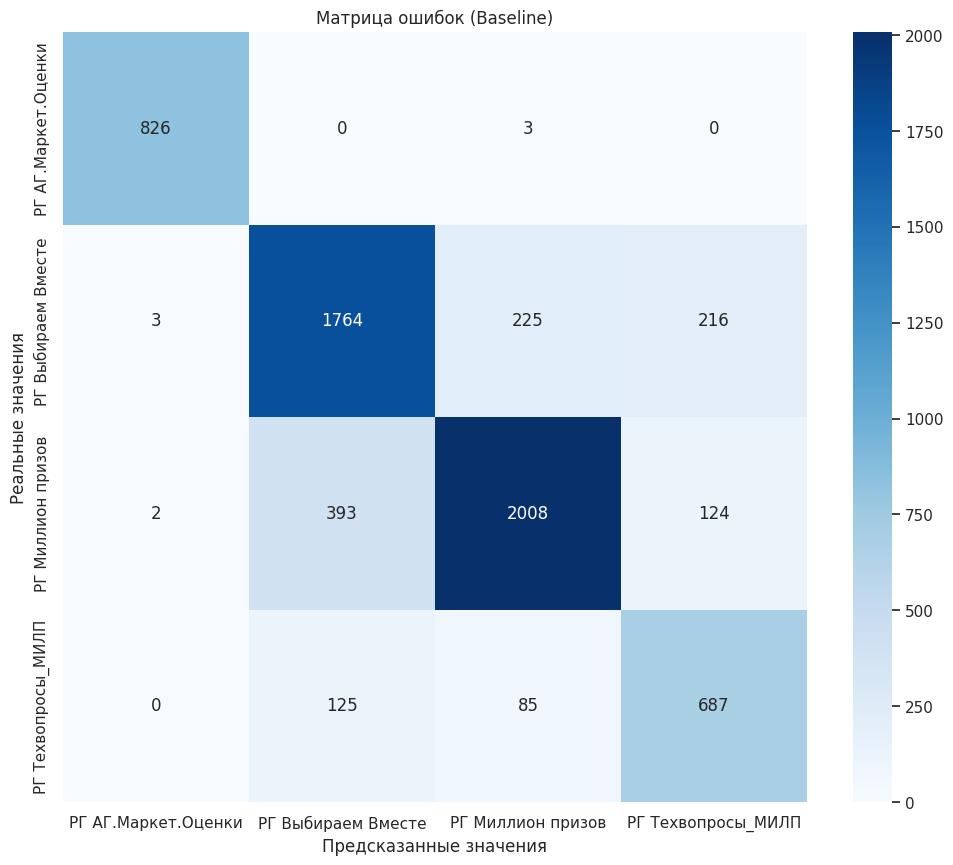

In [20]:
# Добавим ячейку с визуализацией «Матрицы ошибок» (Confusion Matrix)

import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Строим матрицу ошибок
cm = confusion_matrix(y_val, y_pred_val)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=model_lr.classes_,
            yticklabels=model_lr.classes_)
plt.title('Матрица ошибок (Baseline)')
plt.ylabel('Реальные значения')
plt.xlabel('Предсказанные значения')
plt.show()

In [24]:
# Применим градиентный бустинг — CatBoos

# 1. Установка
!pip install catboost

from catboost import CatBoostClassifier

# 2. Создание и обучение модели
# CatBoost сам умеет работать с текстом, но мы подадим ему наши TF-IDF вектора
model_cb = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    loss_function='MultiClass',
    random_seed=42,
    verbose=100 # будет показывать прогресс каждые 100 шагов
)

model_cb.fit(X_train, y_train, eval_set=(X_val, y_val))

# 3. Проверка на валидации
y_pred_cb = model_cb.predict(X_val)

print("Результаты CatBoost на валидации:")
print(classification_report(y_val, y_pred_cb))

0:	learn: 1.2520368	test: 1.2538221	best: 1.2538221 (0)	total: 9.06s	remaining: 1h 15m 19s
100:	learn: 0.5187750	test: 0.5338442	best: 0.5338442 (100)	total: 5m 31s	remaining: 21m 49s
200:	learn: 0.4763420	test: 0.5035285	best: 0.5035285 (200)	total: 10m 25s	remaining: 15m 30s
300:	learn: 0.4596146	test: 0.4932844	best: 0.4932844 (300)	total: 15m 17s	remaining: 10m 6s
400:	learn: 0.4483802	test: 0.4874627	best: 0.4874627 (400)	total: 20m 10s	remaining: 4m 58s
499:	learn: 0.4405952	test: 0.4841851	best: 0.4841851 (499)	total: 24m 56s	remaining: 0us

bestTest = 0.4841851039
bestIteration = 499

Результаты CatBoost на валидации:
                     precision    recall  f1-score   support

РГ АГ.Маркет.Оценки       0.99      1.00      1.00       829
 РГ Выбираем Вместе       0.75      0.81      0.78      2208
  РГ Миллион призов       0.82      0.83      0.83      2527
 РГ Техвопросы_МИЛП       0.81      0.63      0.71       897

           accuracy                           0.82      646

In [25]:
# Финальный тест

from sklearn.metrics import classification_report

# Предсказание на отложенном тесте
y_pred_test = model_cb.predict(X_test)

print("ИТОГОВЫЕ РЕЗУЛЬТАТЫ НА ТЕСТОВОЙ ВЫБОРКЕ (CatBoost):")
print(classification_report(y_test, y_pred_test))

ИТОГОВЫЕ РЕЗУЛЬТАТЫ НА ТЕСТОВОЙ ВЫБОРКЕ (CatBoost):
                     precision    recall  f1-score   support

РГ АГ.Маркет.Оценки       1.00      1.00      1.00      1382
 РГ Выбираем Вместе       0.76      0.81      0.78      3680
  РГ Миллион призов       0.81      0.84      0.82      4213
 РГ Техвопросы_МИЛП       0.80      0.61      0.69      1494

           accuracy                           0.82     10769
          macro avg       0.84      0.81      0.82     10769
       weighted avg       0.82      0.82      0.81     10769



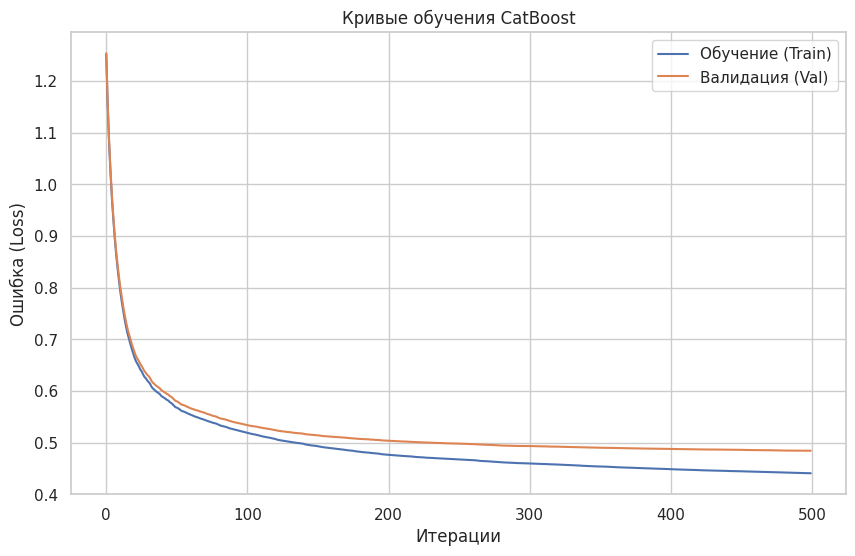

In [26]:
# Анализ переобучения

# График обучения (Loss Curves)
import matplotlib.pyplot as plt

evals_result = model_cb.get_evals_result()
plt.figure(figsize=(10, 6))
plt.plot(evals_result['learn']['MultiClass'], label='Обучение (Train)')
plt.plot(evals_result['validation']['MultiClass'], label='Валидация (Val)')
plt.title('Кривые обучения CatBoost')
plt.xlabel('Итерации')
plt.ylabel('Ошибка (Loss)')
plt.legend()
plt.show()

In [27]:
# Финальный отчет

from sklearn.metrics import classification_report, f1_score

# Получаем предсказания
y_pred_cb = model_cb.predict(X_val)

print("--- ОТЧЕТ ПО МОДЕЛИ CATBOOST (ВАЛИДАЦИЯ) ---")
print(classification_report(y_val, y_pred_cb))

# Сохраним итоговый F1 для истории
final_f1 = f1_score(y_val, y_pred_cb, average='weighted')
print(f"Итоговый взвешенный F1-score: {final_f1:.4f}")

--- ОТЧЕТ ПО МОДЕЛИ CATBOOST (ВАЛИДАЦИЯ) ---
                     precision    recall  f1-score   support

РГ АГ.Маркет.Оценки       0.99      1.00      1.00       829
 РГ Выбираем Вместе       0.75      0.81      0.78      2208
  РГ Миллион призов       0.82      0.83      0.83      2527
 РГ Техвопросы_МИЛП       0.81      0.63      0.71       897

           accuracy                           0.82      6461
          macro avg       0.84      0.82      0.83      6461
       weighted avg       0.82      0.82      0.82      6461

Итоговый взвешенный F1-score: 0.8162
